In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras
from scipy import stats
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

In [249]:
X_train = pd.read_csv('../data/train_clean.csv', index_col='Date').drop(columns='Unnamed: 0')
X_val = pd.read_csv('../data/val_clean.csv', index_col='Date').drop(columns='Unnamed: 0')
X_test = pd.read_csv('../data/test_clean.csv', index_col='Date').drop(columns='Unnamed: 0')

In [250]:
X_train.index = pd.to_datetime(X_train.index)
X_val.index = pd.to_datetime(X_val.index)
X_test.index = pd.to_datetime(X_test.index)

In [251]:
y_train = X_train.pop('Weekly_Sales')
y_val = X_val.pop('Weekly_Sales')
y_test = X_test.pop('Weekly_Sales')


In [252]:
y_train_ts = y_train.resample('1W').sum()
y_val_ts = y_val.resample('1W').sum()
y_test_ts = y_test.resample('1W').sum()

In [253]:
y_train_ts.sort_index(inplace=True)
y_val_ts.sort_index(inplace=True)
y_test_ts.sort_index(inplace=True)

In [254]:
def windowize_data(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[indices, None]
    return x, y

def split_and_windowize(data, n_prev, fraction_test=0.2):
    n_predictions = len(data) - 2*n_prev
    
    n_test  = int(fraction_test * n_predictions)
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev)
    x_test, y_test = windowize_data(data[n_train:], n_prev)
    return x_train, x_test, y_train, y_test

In [255]:
n_prev = 10

X_train_window, y_train_window = windowize_data(y_train_ts, n_prev)
X_val_window, y_val_window = windowize_data(y_val_ts, n_prev)
X_test_window, y_test_window = windowize_data(y_test_ts, n_prev)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


In [256]:
y_pred = X_test_window[:,-1]
np.mean(keras.losses.mean_squared_error(y_test_window, y_pred)) 


7952428064142.636

In [273]:
y_train_window.mean(), y_val_window.mean(), y_test_window.mean()

(21149169.606240608, 10373634.820601502, 15598827.752631586)

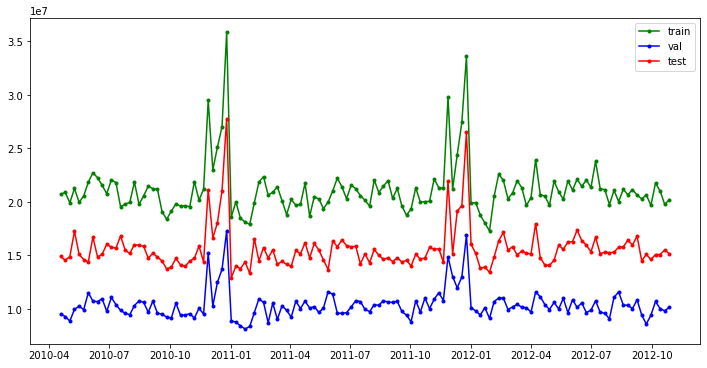

In [261]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(y_train_window.index, y_train_window, 'g.-', label='train')
ax.plot(y_val_window.index, y_val_window, 'b.-', label='val')
ax.plot(y_test_window.index, y_test_window, 'r.-', label='test')
ax.legend();

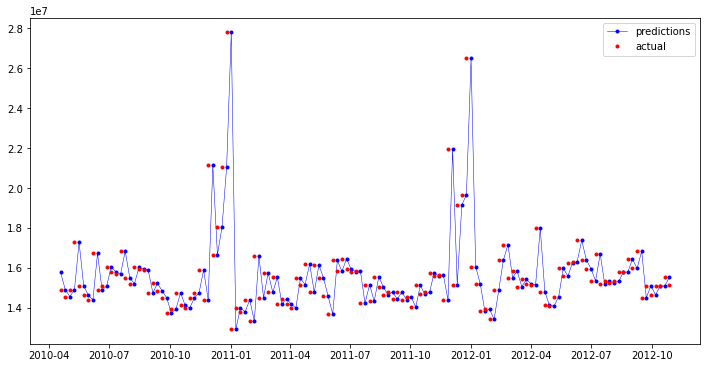

In [259]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(y_test_window.index, y_pred, 'b.-', label='predictions', lw=0.5)
ax.plot(y_test_window.index, y_test_window, 'r.', label='actual')
ax.legend();

In [275]:
X_train_window, y_train_window

(array([[[22729893.70000001],
         [21622763.09000003],
         [21519570.12000002],
         ...,
         [20206457.75999999],
         [23117172.19      ],
         [21027113.97000002]],
 
        [[21622763.09000003],
         [21519570.12000002],
         [19254925.51000001],
         ...,
         [23117172.19      ],
         [21027113.97000002],
         [20735785.51999998]],
 
        [[21519570.12000002],
         [19254925.51000001],
         [20379672.23999999],
         ...,
         [21027113.97000002],
         [20735785.51999998],
         [20886830.60000002]],
 
        ...,
 
        [[21078134.86000005],
         [20044932.36000002],
         [21183873.47      ],
         ...,
         [20662394.66000001],
         [19680921.81999999],
         [21771363.04999997]],
 
        [[20044932.36000002],
         [21183873.47      ],
         [20676155.28999999],
         ...,
         [19680921.81999999],
         [21771363.04999997],
         [21018904.47000002]],
 


In [276]:
model = keras.models.Sequential([keras.layers.LSTM(20, return_sequences=True, input_shape=(n_prev, 1)), 
                                 keras.layers.LSTM(20, return_sequences=True), 
                                 keras.layers.TimeDistributed(keras.layers.Dense(1))]) 




model.compile(optimizer='rmsprop', loss='mse')

In [290]:
n = 100

model = keras.Sequential()
model.add(keras.layers.LSTM(n, input_shape=(n_prev, 1), return_sequences=True))
model.add(keras.layers.LSTM(n, return_sequences=True))
model.add(keras.layers.LSTM(n, return_sequences=True))
model.add(keras.layers.LSTM(n, return_sequences=True))
model.add(keras.layers.LSTM(n, return_sequences=False))
model.add(keras.layers.Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse')

In [300]:
# checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
model.fit(X_train_window, y_train_window, epochs=300, batch_size=16, validation_data=(X_val_window, y_val_window)) 



Epoch 1/300
9/9 [==============================] - 0s 36ms/step - loss: 453466338099200.0000 - val_loss: 109431790501888.0000
Epoch 2/300
9/9 [==============================] - 0s 29ms/step - loss: 453466270990336.0000 - val_loss: 109431773724672.0000
Epoch 3/300
9/9 [==============================] - 0s 30ms/step - loss: 453466270990336.0000 - val_loss: 109431748558848.0000
Epoch 4/300
9/9 [==============================] - 0s 30ms/step - loss: 453466237435904.0000 - val_loss: 109431715004416.0000
Epoch 5/300
9/9 [==============================] - 0s 29ms/step - loss: 453466170327040.0000 - val_loss: 109431706615808.0000
Epoch 6/300
9/9 [==============================] - 0s 34ms/step - loss: 453466170327040.0000 - val_loss: 109431706615808.0000
Epoch 7/300
9/9 [==============================] - 0s 35ms/step - loss: 453466069663744.0000 - val_loss: 109431689838592.0000
Epoch 8/300
9/9 [==============================] - 0s 30ms/step - loss: 453466069663744.0000 - val_loss: 1094316562841

9/9 [==============================] - 0s 28ms/step - loss: 453463922180096.0000 - val_loss: 109430582542336.0000
Epoch 66/300
9/9 [==============================] - 0s 27ms/step - loss: 453463821516800.0000 - val_loss: 109430557376512.0000
Epoch 67/300
9/9 [==============================] - 0s 31ms/step - loss: 453463821516800.0000 - val_loss: 109430532210688.0000
Epoch 68/300
9/9 [==============================] - 0s 27ms/step - loss: 453463720853504.0000 - val_loss: 109430515433472.0000
Epoch 69/300
9/9 [==============================] - 0s 27ms/step - loss: 453463720853504.0000 - val_loss: 109430507044864.0000
Epoch 70/300
9/9 [==============================] - 0s 27ms/step - loss: 453463687299072.0000 - val_loss: 109430481879040.0000
Epoch 71/300
9/9 [==============================] - 0s 28ms/step - loss: 453463653744640.0000 - val_loss: 109430481879040.0000
Epoch 72/300
9/9 [==============================] - 0s 28ms/step - loss: 453463653744640.0000 - val_loss: 109430465101824.00

9/9 [==============================] - 0s 29ms/step - loss: 453461439152128.0000 - val_loss: 109429382971392.0000
Epoch 130/300
9/9 [==============================] - 0s 29ms/step - loss: 453461372043264.0000 - val_loss: 109429357805568.0000
Epoch 131/300
9/9 [==============================] - 0s 30ms/step - loss: 453461372043264.0000 - val_loss: 109429332639744.0000
Epoch 132/300
9/9 [==============================] - 0s 28ms/step - loss: 453461304934400.0000 - val_loss: 109429315862528.0000
Epoch 133/300
9/9 [==============================] - 0s 30ms/step - loss: 453461304934400.0000 - val_loss: 109429315862528.0000
Epoch 134/300
9/9 [==============================] - 0s 29ms/step - loss: 453461237825536.0000 - val_loss: 109429299085312.0000
Epoch 135/300
9/9 [==============================] - 0s 29ms/step - loss: 453461237825536.0000 - val_loss: 109429273919488.0000
Epoch 136/300
9/9 [==============================] - 0s 28ms/step - loss: 453461204271104.0000 - val_loss: 10942924036

9/9 [==============================] - 0s 39ms/step - loss: 453458956124160.0000 - val_loss: 109428175011840.0000
Epoch 194/300
9/9 [==============================] - 0s 45ms/step - loss: 453458956124160.0000 - val_loss: 109428175011840.0000
Epoch 195/300
9/9 [==============================] - 0s 35ms/step - loss: 453458855460864.0000 - val_loss: 109428149846016.0000
Epoch 196/300
9/9 [==============================] - 0s 38ms/step - loss: 453458855460864.0000 - val_loss: 109428133068800.0000
Epoch 197/300
9/9 [==============================] - 0s 35ms/step - loss: 453458788352000.0000 - val_loss: 109428107902976.0000
Epoch 198/300
9/9 [==============================] - 0s 38ms/step - loss: 453458788352000.0000 - val_loss: 109428091125760.0000
Epoch 199/300
9/9 [==============================] - 0s 39ms/step - loss: 453458721243136.0000 - val_loss: 109428074348544.0000
Epoch 200/300
9/9 [==============================] - 0s 42ms/step - loss: 453458754797568.0000 - val_loss: 10942805757

9/9 [==============================] - 0s 34ms/step - loss: 453456540205056.0000 - val_loss: 109426983829504.0000
Epoch 258/300
9/9 [==============================] - 0s 29ms/step - loss: 453456540205056.0000 - val_loss: 109426975440896.0000
Epoch 259/300
9/9 [==============================] - 0s 31ms/step - loss: 453456506650624.0000 - val_loss: 109426950275072.0000
Epoch 260/300
9/9 [==============================] - 0s 29ms/step - loss: 453456439541760.0000 - val_loss: 109426933497856.0000
Epoch 261/300
9/9 [==============================] - 0s 29ms/step - loss: 453456338878464.0000 - val_loss: 109426908332032.0000
Epoch 262/300
9/9 [==============================] - 0s 29ms/step - loss: 453456338878464.0000 - val_loss: 109426883166208.0000
Epoch 263/300
9/9 [==============================] - 0s 29ms/step - loss: 453456338878464.0000 - val_loss: 109426874777600.0000
Epoch 264/300
9/9 [==============================] - 0s 29ms/step - loss: 453456238215168.0000 - val_loss: 10942687477

In [305]:
y_pred = model.predict(X_test_window)

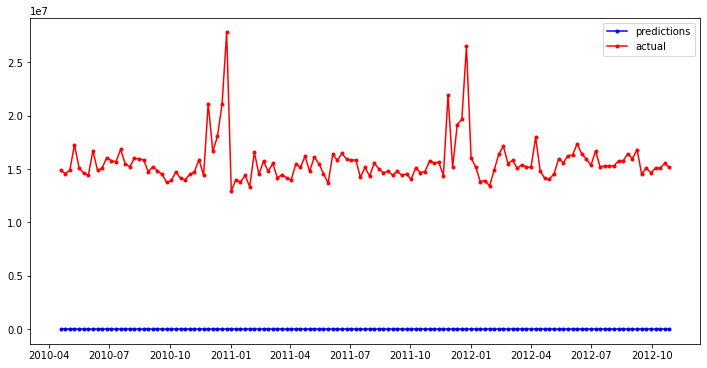

In [306]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(y_test_window.index, y_pred, 'b.-', label='predictions')
ax.plot(y_test_window.index, y_test_window, 'r.-', label='actual')
ax.legend()
ax.set_title();

In [307]:
y_pred

array([[330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],
       [330.84363],


In [308]:
y_test_ts

Date
2010-02-07    16949557.13
2010-02-14    15527423.02
2010-02-21    14904971.83
2010-02-28    14857999.27
2010-03-07    15453439.03
                 ...     
2012-09-30    14635362.30
2012-10-07    15089821.07
2012-10-14    15084853.00
2012-10-21    15527171.68
2012-10-28    15149850.40
Freq: W-SUN, Name: Weekly_Sales, Length: 143, dtype: float64